In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pyfolio as pf

from calculate_max_dd import calculateMaxDD

# Константы
ticker1 = 'MSI'
ticker2 = 'WELL'

open_threshold = 0.75
close_threshold = 0.25

oneway_trans_cost=0.0005

In [15]:
tickers = pd.read_parquet('../data/sp500_stocks.parquet')
tickers.set_index('ticker', inplace=True)
tickers

,company,sector,industry
ticker,,,
MMM,3M,Industrials,Industrial Conglomerates
AOS,A. O. Smith,Industrials,Building Products
ABT,Abbott Laboratories,Health Care,Health Care Equipment
ABBV,AbbVie,Health Care,Biotechnology
ACN,Accenture,Information Technology,IT Consulting & Other Services
...,...,...,...
XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components
YUM,Yum! Brands,Consumer Discretionary,Restaurants
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments


In [16]:
# test = pd.read_parquet('../data/sp500_2023-01-01_2025-01-01.parquet')[[('Open', 'RSG'), ('Close', 'RSG')]]
# test

# prev_close = test['Close'].shift(1)
# curr_open = test['Open']

# # Combine into a DataFrame
# pair = pd.concat([prev_close, curr_open], axis=1)
# pair.columns = ['Prev_Close', 'Curr_Open']
# pair['Spread'] = pair['Curr_Open'] - pair['Prev_Close']
# pair['Spread'] = pair['Spread'].fillna(0)
# print(f"Spread mean between closing price and opening price: {pair['Spread'].mean()}")
# print(f"Spread std between closing price and opening price: {pair['Spread'].std()}")

history = pd.read_parquet('../data/sp500_2023-01-01_2025-01-01.parquet')['Adj Close']
# FIXME: а не добавили ли мы здесь Look-Ahead bias? Цена закрытия известна в конце дня, когда мы уже купить не можем
#        и это значит что позицию мы смогли бы открыть только на следующий день. Нужно проверить, учитывается ли это в расчете PnL?
history

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,147.307404,123.470604,146.532608,84.900002,103.829872,59.393120,259.429932,336.920013,155.368591,82.784058,...,28.041914,83.575516,64.169846,97.812393,107.466949,64.639999,121.015472,124.631607,260.200012,142.700806
2023-01-04,148.907715,124.744125,147.714798,88.720001,105.374336,59.687901,258.546783,341.410004,158.677811,79.773720,...,28.378126,88.739807,64.719322,98.097076,107.301987,66.300003,122.654922,125.787064,262.989990,144.751190
2023-01-05,149.339691,123.421249,147.534286,87.709999,104.985840,59.849552,252.441681,328.440002,152.728912,77.779160,...,27.533051,89.169342,63.409740,100.291901,104.255356,64.709999,121.720810,123.456581,260.059998,141.340347
2023-01-06,144.980545,127.962418,150.295670,88.519997,106.435570,60.762417,258.422028,332.750000,158.304779,79.367409,...,28.723425,91.346367,65.287125,101.504120,107.961777,68.989998,124.189529,123.084480,273.420013,143.468475
2023-01-09,144.784195,128.485626,145.882874,89.239998,106.265007,59.592808,262.780060,341.980011,159.815903,78.831848,...,28.550772,92.088295,65.919022,99.612328,108.466316,69.059998,123.684364,123.427193,279.290009,142.904846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,135.276016,257.578674,175.172623,134.990005,113.126747,92.669998,358.322815,447.940002,216.161057,49.560802,...,27.837301,88.309021,66.534348,104.494308,117.409760,91.080002,133.709183,106.553841,395.440002,163.105942
2024-12-26,135.007660,258.396667,174.394058,135.320007,113.629478,92.930000,357.133789,450.160004,216.131317,49.541222,...,27.748646,88.836212,66.505081,104.582695,117.727753,91.480003,134.699615,106.504189,396.850006,163.918030
2024-12-27,134.719406,254.974930,173.235977,133.384995,113.353477,92.339996,352.922638,446.480011,215.070786,49.511856,...,27.571339,88.209557,66.466064,104.572884,116.793640,88.970001,133.936966,106.126823,389.070007,163.006927


In [17]:
training_set = history[[ticker1, ticker2]].copy()
training_set

Ticker,MSI,WELL
Date,,
2023-01-03,250.301926,62.881371
2023-01-04,250.904831,64.656509
2023-01-05,248.084808,63.294636
2023-01-06,256.564362,65.539398
2023-01-09,253.423416,65.060371
...,...,...
2024-12-24,469.963074,125.445755
2024-12-26,468.829071,125.247566
2024-12-27,464.870026,123.870125


Нарисуем как выглядят цены на эти позиции

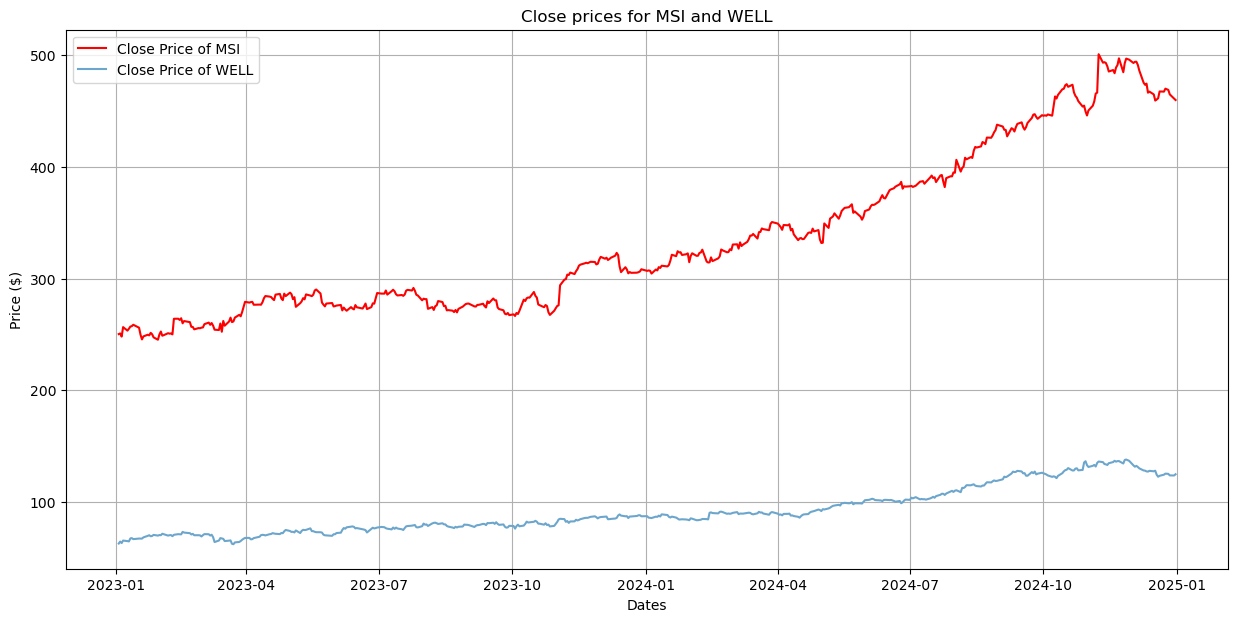

In [18]:
# Customise the size of the plot
plt.figure(figsize=(15, 7))
plt.plot(training_set[ticker1], lw=1.5, label=f"Close Price of {ticker1}",color='red')
plt.plot(training_set[ticker2], lw=1.5, label=f"Close Price of {ticker2}",color='#6CA6CD')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price ($)')
plt.title(f"Close prices for {ticker1} and {ticker2}")
plt.grid(True);
plt.show()

Расчитываем hedge ratio. По сути, просто расчитываем на что нужно умножить цену второй акции, чтобы они были примерно одинаковыми.

In [19]:
hedge_ratio = sm.OLS(training_set[ticker1], training_set[ticker2]).fit().params
hedge_ratio.iloc[0]

np.float64(3.6456087944374405)

Что бы это понять, нарисуем график цен, но уже с учетом hedge ratio

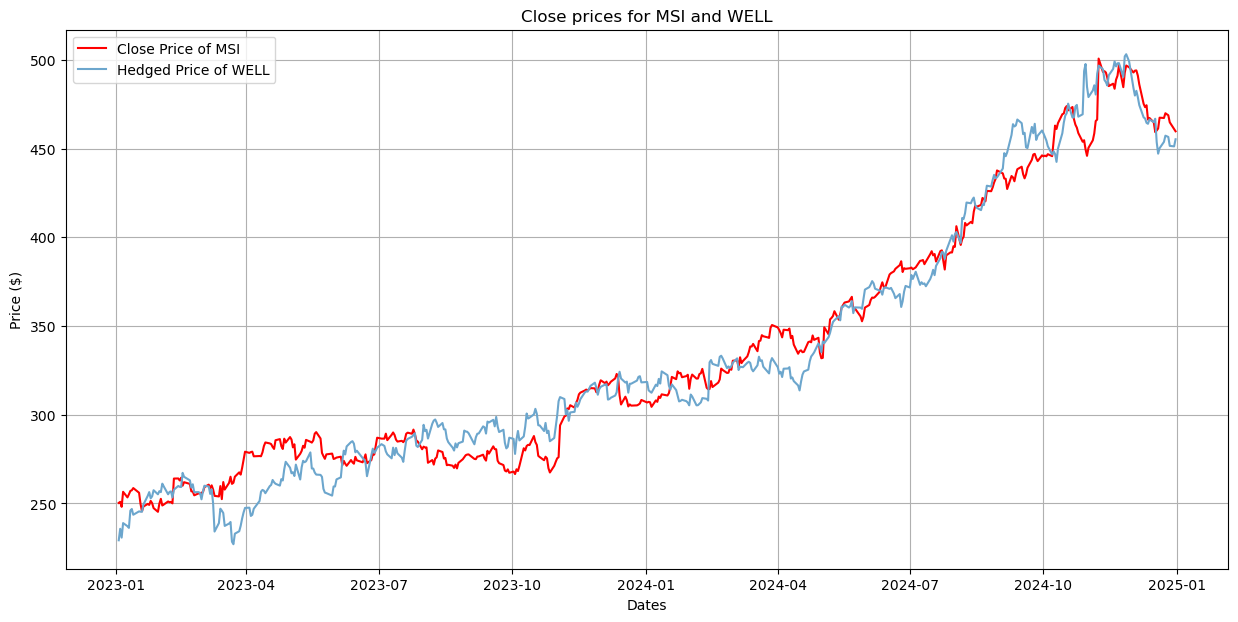

In [38]:
hedged_prices = training_set[ticker2] * hedge_ratio.iloc[0]
plt.figure(figsize=(15, 7))
plt.plot(training_set[ticker1], lw=1.5, label=f"Close Price of {ticker1}",color='red')
plt.plot(hedged_prices, lw=1.5, label=f"Hedged Price of {ticker2}",color='#6CA6CD')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Price ($)')
plt.title(f"Close prices for {ticker1} and {ticker2}")
plt.grid(True);
plt.show()

Расчитываем спред между двумя позициями c учетом хеджирования

In [20]:
spread = training_set[ticker1] - hedge_ratio.iloc[0] * training_set[ticker2]
spread

Date
2023-01-03    21.061048
2023-01-04    15.192492
2023-01-05    17.337328
2023-01-06    17.633355
2023-01-09    16.238754
                ...    
2024-12-24    12.636926
2024-12-26    12.225442
2024-12-27    13.288009
2024-12-30     9.856658
2024-12-31     4.493849
Length: 502, dtype: float64

In [21]:
spread_mean = spread.mean()
spread_mean

np.float64(0.893109450849391)

In [22]:
spread_std = spread.std()
spread_std

13.84068779587592

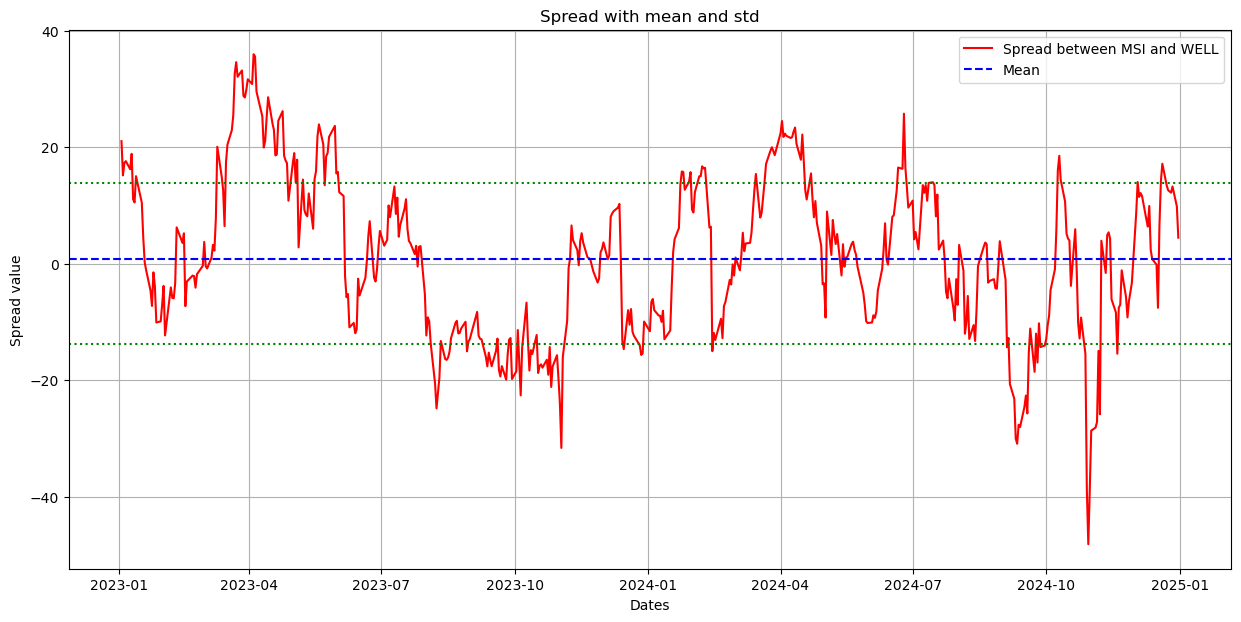

In [23]:
# Customise the size of the plot
plt.figure(figsize=(15, 7))
plt.plot(spread, lw=1.5, label=f'Spread between {ticker1} and {ticker2}',color='red')
plt.axhline(y=spread_mean, color='blue', linestyle='--', label="Mean")
plt.axhline(y=spread_std, color='green', linestyle=':')
plt.axhline(y=-spread_std, color='green', linestyle=':')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Spread value')
plt.title('Spread with mean and std')
plt.grid(True);
plt.show()

Расчитываем zscore пары

In [24]:
training_set['zscore'] = (spread - spread_mean) / spread_std
training_set

# Расчитать thresholds на основе стандартного отклонения отрытие равно 1 стд отклонению, а закрытие половине

Ticker,MSI,WELL,zscore
Date,,,
2023-01-03,250.301926,62.881371,1.457149
2023-01-04,250.904831,64.656509,1.033141
2023-01-05,248.084808,63.294636,1.188107
2023-01-06,256.564362,65.539398,1.209495
2023-01-09,253.423416,65.060371,1.108734
...,...,...,...
2024-12-24,469.963074,125.445755,0.848499
2024-12-26,468.829071,125.247566,0.818769
2024-12-27,464.870026,123.870125,0.895541


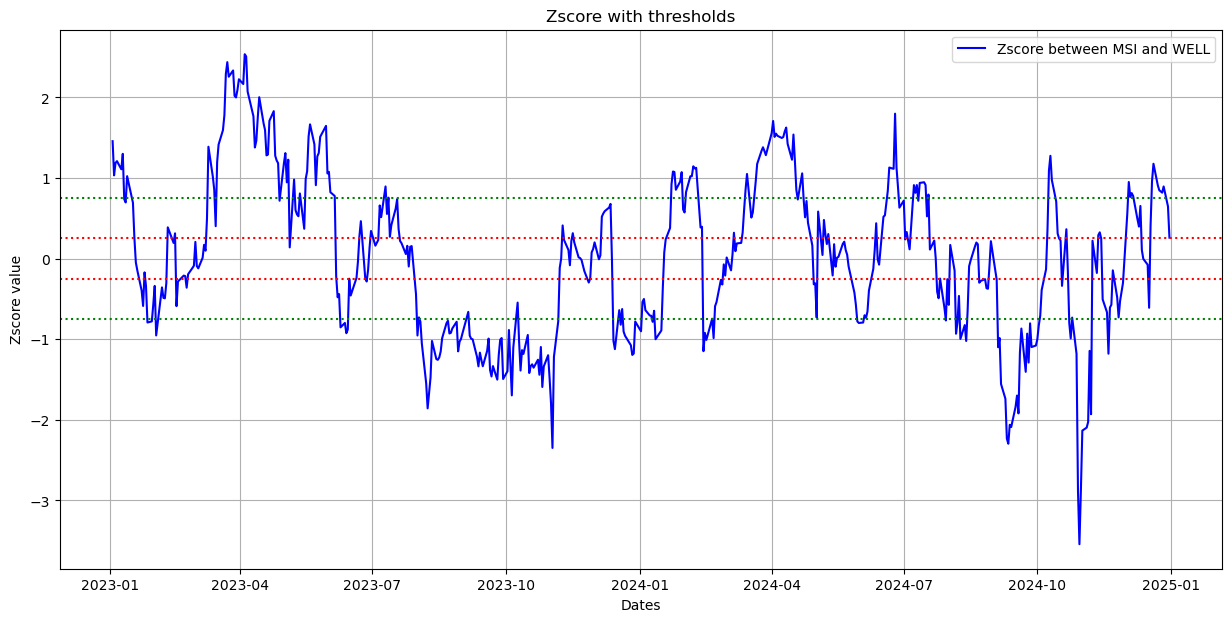

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(training_set['zscore'], lw=1.5, label=f'Zscore between {ticker1} and {ticker2}',color='blue')
plt.axhline(y=open_threshold, color='green', linestyle=':')
plt.axhline(y=-open_threshold, color='green', linestyle=':')
plt.axhline(y=close_threshold, color='red', linestyle=':')
plt.axhline(y=-close_threshold, color='red', linestyle=':')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.ylabel('Zscore value')
plt.title('Zscore with thresholds')
plt.grid(True);
plt.show()

Я не сразу понял почему именно так называются колонки и что они отражают. Суть в том, что лонгом пары называется когда мы тикер открываем лонг на первый тикер и шорт на второй, а шортом пары когда наоборот открываем шорт первого тикера и лонг второго.

In [26]:
training_set['pos_1_long'] = 0
training_set['pos_2_long'] = 0
training_set['pos_1_short'] = 0
training_set['pos_2_short'] = 0
training_set.loc[training_set.zscore >= open_threshold, ('pos_1_short', 'pos_2_short')] = [ -1, 1 ] # Short spread
training_set.loc[training_set.zscore <= -open_threshold, ('pos_1_long', 'pos_2_long')] = [ 1, -1 ] # Long spread
training_set.loc[training_set.zscore <= close_threshold, ('pos_1_short', 'pos_2_short')] = 0 # Close position short
training_set.loc[training_set.zscore >= -close_threshold, ('pos_1_long', 'pos_2_long')] = 0 # Close position long

training_set.ffill(inplace=True)

In [27]:
longs = training_set.loc[:, ('pos_1_long', 'pos_2_long')]
shorts = training_set.loc[:, ('pos_1_short', 'pos_2_short')]

Складываем по элементам массивы, в результирующем массиве будет 2 колонки, первая отражает держим ли мы открытую лонг (1) или шорт (-1) позицию по 1 тикеру, вторая тоже самое про второй тикер.

In [28]:
positions = np.array(longs) + np.array(shorts)
positions = pd.DataFrame(positions)

Датафрейм positions отражает открыты ли позиции на определенный день, правда дней тут нет. Важный момент, перед расчетом PnL позиции смешаются на день, потому что расчет ведется по цене закрытия, а значит позиция будет открыта на следующей день

In [29]:
longs_with_dates = training_set.loc[:, ('pos_1_long', 'pos_2_long')].copy()
longs_with_dates.columns = [ticker1, ticker2]

shorts_with_dates = training_set.loc[:, ('pos_1_short', 'pos_2_short')].copy()
shorts_with_dates.columns = [ticker1, ticker2]

positions_with_dates = longs_with_dates + shorts_with_dates


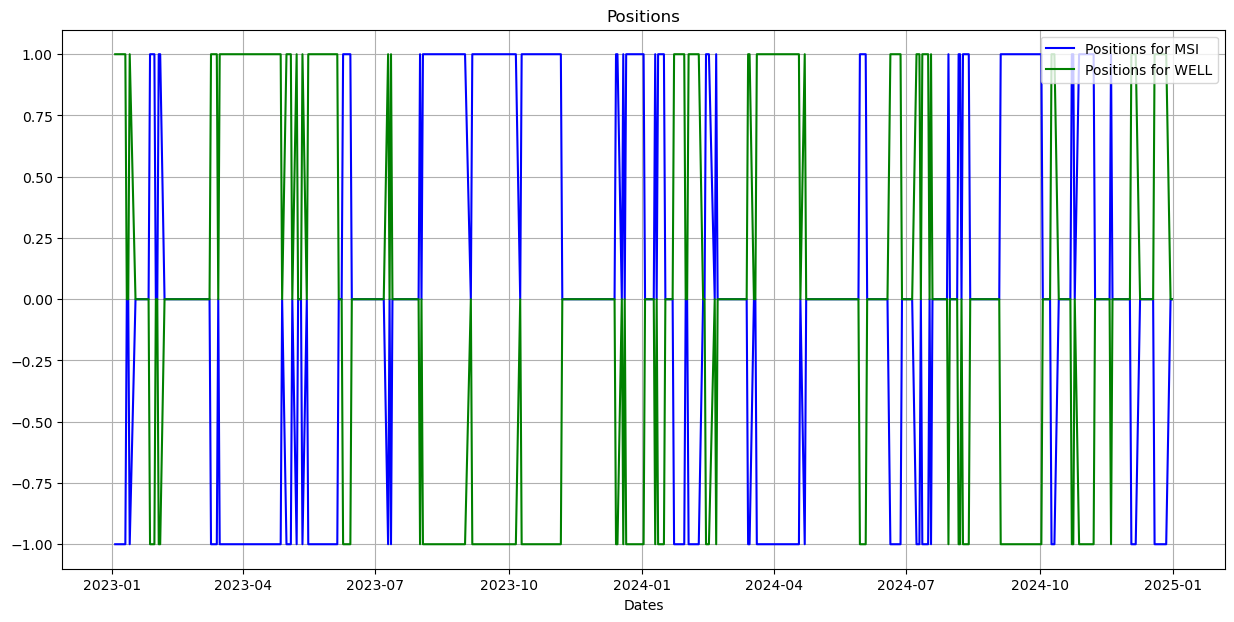

In [30]:
plt.figure(figsize=(15, 7))
plt.plot(positions_with_dates[ticker1], lw=1.5, label=f'Positions for {ticker1}',color='blue')
plt.plot(positions_with_dates[ticker2], lw=1.5, label=f'Positions for {ticker2}',color='green')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.title('Positions')
plt.show()

Считаем как изменилась в процентах цена относительно предыдущего дня

In [31]:
dailyret = training_set.loc[:, (ticker1, ticker2)].pct_change()
dailyret

Ticker,MSI,WELL
Date,,
2023-01-03,NaN,NaN
2023-01-04,0.002409,0.028230
2023-01-05,-0.011239,-0.021063
2023-01-06,0.034180,0.035465
2023-01-09,-0.012242,-0.007309
...,...,...
2024-12-24,0.005705,0.007722
2024-12-26,-0.002413,-0.001580
2024-12-27,-0.008445,-0.010998


Теперь мы у нас есть данные о том, была ли открыта позиция в определенную дату и как отличается цена закрытия сегодня и вчера. Исходя из этих данных мы можем рассчитать profit and loss каждого торгового дня

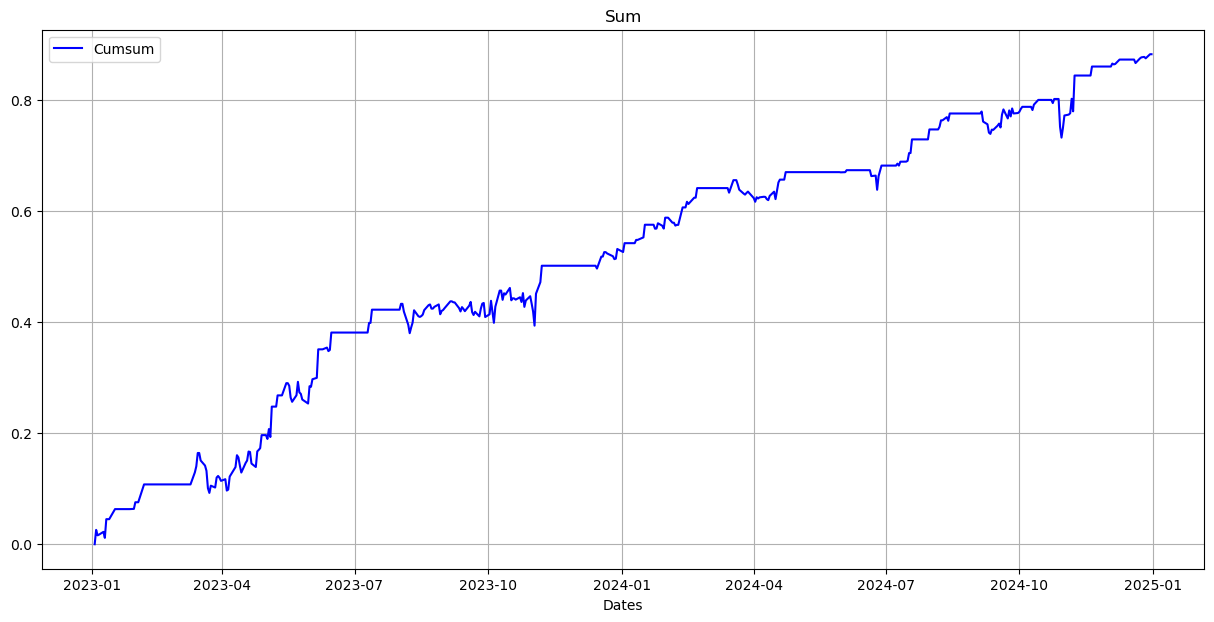

In [32]:
pnl = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1)
# pnl_minus_cost = pnl - (np.nansum(abs(positions-np.array(pd.DataFrame(positions).shift())), axis=1) * oneway_trans_cost)

pnl_with_dates = (positions_with_dates.shift() * dailyret).sum(axis=1)
cumulative_pnl = pnl_with_dates.cumsum()

plt.figure(figsize=(15, 7))
plt.plot(cumulative_pnl, lw=1.5, label=f'Cumsum',color='blue')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.title('Sum')
plt.show()


А теперь сравним с тем, если бы мы просто купили одну из этих акций и держали все это время в лонге.

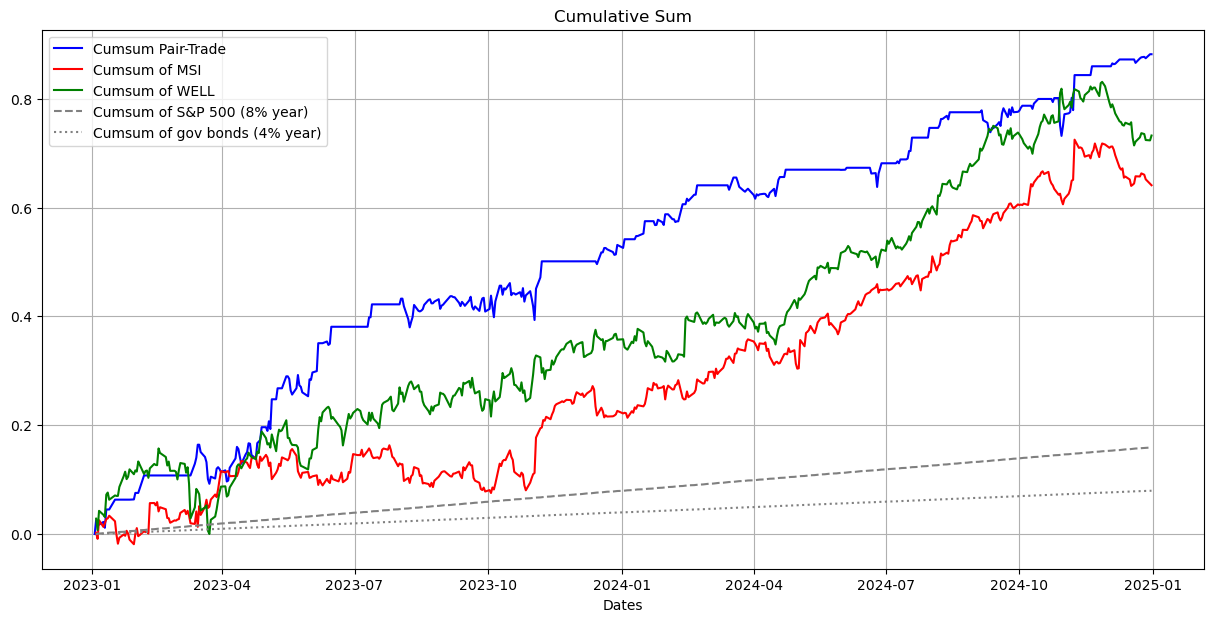

In [33]:
ticker1_dailyret = training_set.loc[:, ticker1].pct_change()
ticker2_dailyret = training_set.loc[:, ticker2].pct_change()
sp_dailyret = training_set.loc[:, ticker1].pct_change()
sp_dailyret = sp_dailyret.where(sp_dailyret.isna(), 0.08 / 252)
bonds_dailyret = training_set.loc[:, ticker1].pct_change()
bonds_dailyret = bonds_dailyret.where(bonds_dailyret.isna(), 0.04 / 252)

plt.figure(figsize=(15, 7))
plt.plot(cumulative_pnl, lw=1.5, label=f'Cumsum Pair-Trade',color='blue')
plt.plot(ticker1_dailyret.cumsum(), lw=1.5, label=f'Cumsum of {ticker1}',color='red')
plt.plot(ticker2_dailyret.cumsum(), lw=1.5, label=f'Cumsum of {ticker2}',color='green')
plt.plot(sp_dailyret.cumsum(), lw=1.5, label=f'Cumsum of S&P 500 (8% year)',color='grey', linestyle='--')
plt.plot(bonds_dailyret.cumsum(), lw=1.5, label=f'Cumsum of gov bonds (4% year)',color='grey', linestyle=':')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.title('Cumulative Sum')
plt.show()

А теперь можно посчитать Sharpe ratio

In [34]:
sharpe_ration = np.sqrt(252) * pnl[1:].mean() / pnl[1:].std()
sharpe_ration

np.float64(2.601458829785128)

А теперь перепроверим значение на out-of-sample значениях.

In [35]:
live = pd.read_parquet('../data/sp500_2025-01-01_2025-07-01.parquet')['Adj Close']
live_set = live[[ticker1, ticker2]].copy()

live_spread = live_set[ticker1] - hedge_ratio.iloc[0] * live_set[ticker2]
live_spread_mean = live_spread.mean()
live_spread_std = live_spread.std()
live_set['zscore'] = (live_spread - live_spread_mean) / live_spread_std

live_set['pos_1_long'] = 0
live_set['pos_2_long'] = 0
live_set['pos_1_short'] = 0
live_set['pos_2_short'] = 0
live_set.loc[live_set.zscore >= open_threshold, ('pos_1_short', 'pos_2_short')] = [ -1, 1 ] # Short spread
live_set.loc[live_set.zscore <= -open_threshold, ('pos_1_long', 'pos_2_long')] = [ 1, -1 ] # Long spread
live_set.loc[live_set.zscore <= close_threshold, ('pos_1_short', 'pos_2_short')] = 0 # Close position short
live_set.loc[live_set.zscore >= -close_threshold, ('pos_1_long', 'pos_2_long')] = 0 # Close position long
live_set.ffill(inplace=True)

live_longs = live_set.loc[:, ('pos_1_long', 'pos_2_long')]
live_shorts = live_set.loc[:, ('pos_1_short', 'pos_2_short')]
live_positions = np.array(live_longs) + np.array(live_shorts)
live_positions = pd.DataFrame(live_positions)

live_dailyret = live_set.loc[:, (ticker1, ticker2)].pct_change()
live_pnl = (np.array(live_positions.shift()) * np.array(live_dailyret)).sum(axis=1)

live_sharpe_ration = np.sqrt(252) * live_pnl[1:].mean() / live_pnl[1:].std()
live_sharpe_ration

np.float64(3.6382100029538798)

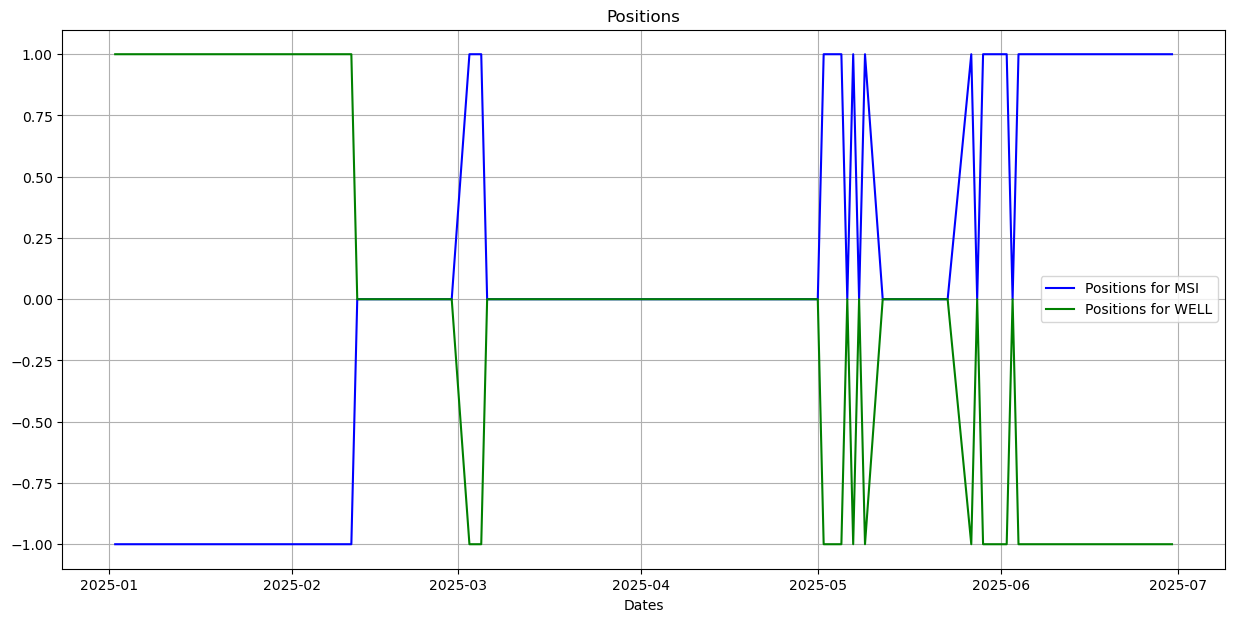

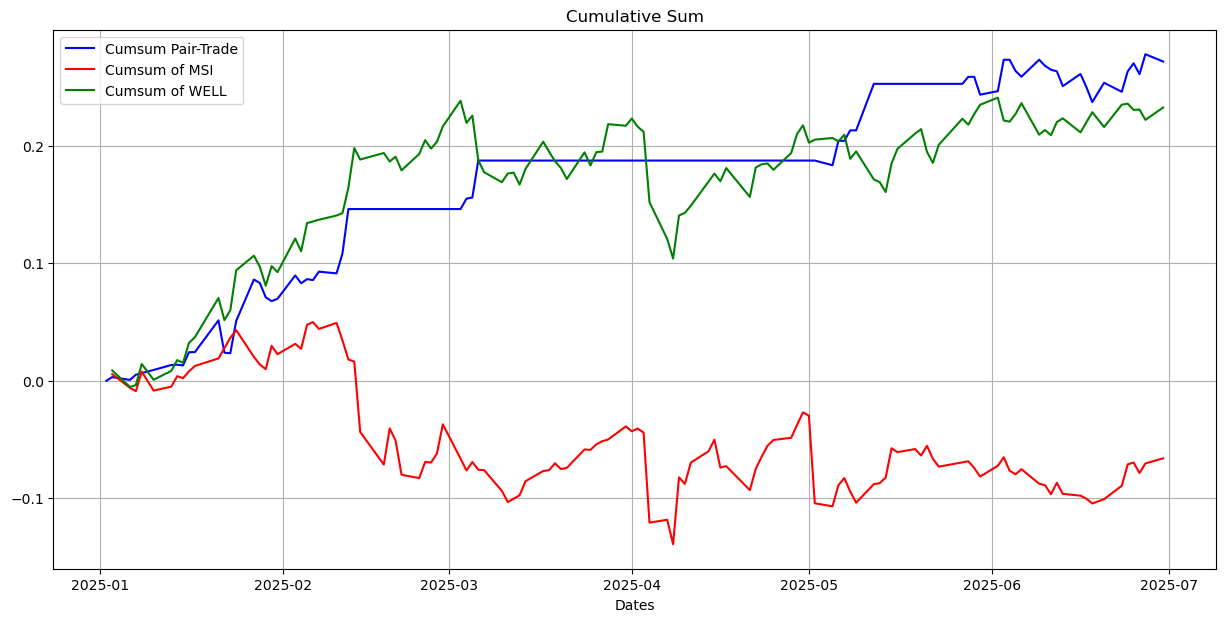

In [36]:
live_longs_with_dates = live_set.loc[:, ('pos_1_long', 'pos_2_long')].copy()
live_longs_with_dates.columns = [ticker1, ticker2]

live_shorts_with_dates = live_set.loc[:, ('pos_1_short', 'pos_2_short')].copy()
live_shorts_with_dates.columns = [ticker1, ticker2]

live_positions_with_dates = live_longs_with_dates + live_shorts_with_dates

plt.figure(figsize=(15, 7))
plt.plot(live_positions_with_dates[ticker1], lw=1.5, label=f'Positions for {ticker1}',color='blue')
plt.plot(live_positions_with_dates[ticker2], lw=1.5, label=f'Positions for {ticker2}',color='green')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.title('Positions')
plt.show()

live_pnl_with_dates = (live_positions_with_dates.shift() * live_dailyret).sum(axis=1)
live_cumulative_pnl = live_pnl_with_dates.cumsum()

live_ticker1_dailyret = live_set.loc[:, ticker1].pct_change()
live_ticker2_dailyret = live_set.loc[:, ticker2].pct_change()

plt.figure(figsize=(15, 7))
plt.plot(live_cumulative_pnl, lw=1.5, label=f'Cumsum Pair-Trade',color='blue')
plt.plot(live_ticker1_dailyret.cumsum(), lw=1.5, label=f'Cumsum of {ticker1}',color='red')
plt.plot(live_ticker2_dailyret.cumsum(), lw=1.5, label=f'Cumsum of {ticker2}',color='green')
plt.grid(True)
plt.legend(loc=0)

# This helps us tighten the figure margins
plt.axis('tight')
plt.xlabel('Dates')
plt.title('Cumulative Sum')
plt.show()

/Users/dmitriifalko/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '53.403%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2023-01-03
End date,2024-12-31
Total months,23
,Backtest
Annual return,53.403%
Cumulative returns,134.528%
Annual volatility,17.049%
Sharpe ratio,2.60
Calmar ratio,7.63
Stability,0.96
Max drawdown,-6.998%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.00,2023-03-16,2023-03-23,2023-04-19,25
1,6.85,2024-10-28,2024-10-30,2024-11-08,10
2,6.69,2023-10-16,2023-11-02,2023-11-06,16
3,5.19,2023-08-03,2023-08-08,2023-09-05,24
4,3.97,2024-09-05,2024-09-11,2024-09-20,12


/Users/dmitriifalko/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])
/Users/dmitriifalko/.pyenv/versions/miniconda3-latest/lib/python3.13/site-packages/pyfolio/tears.py:1005: UserWarning: Passed returns do not overlap with anyinteresting times.
  warnings.warn(


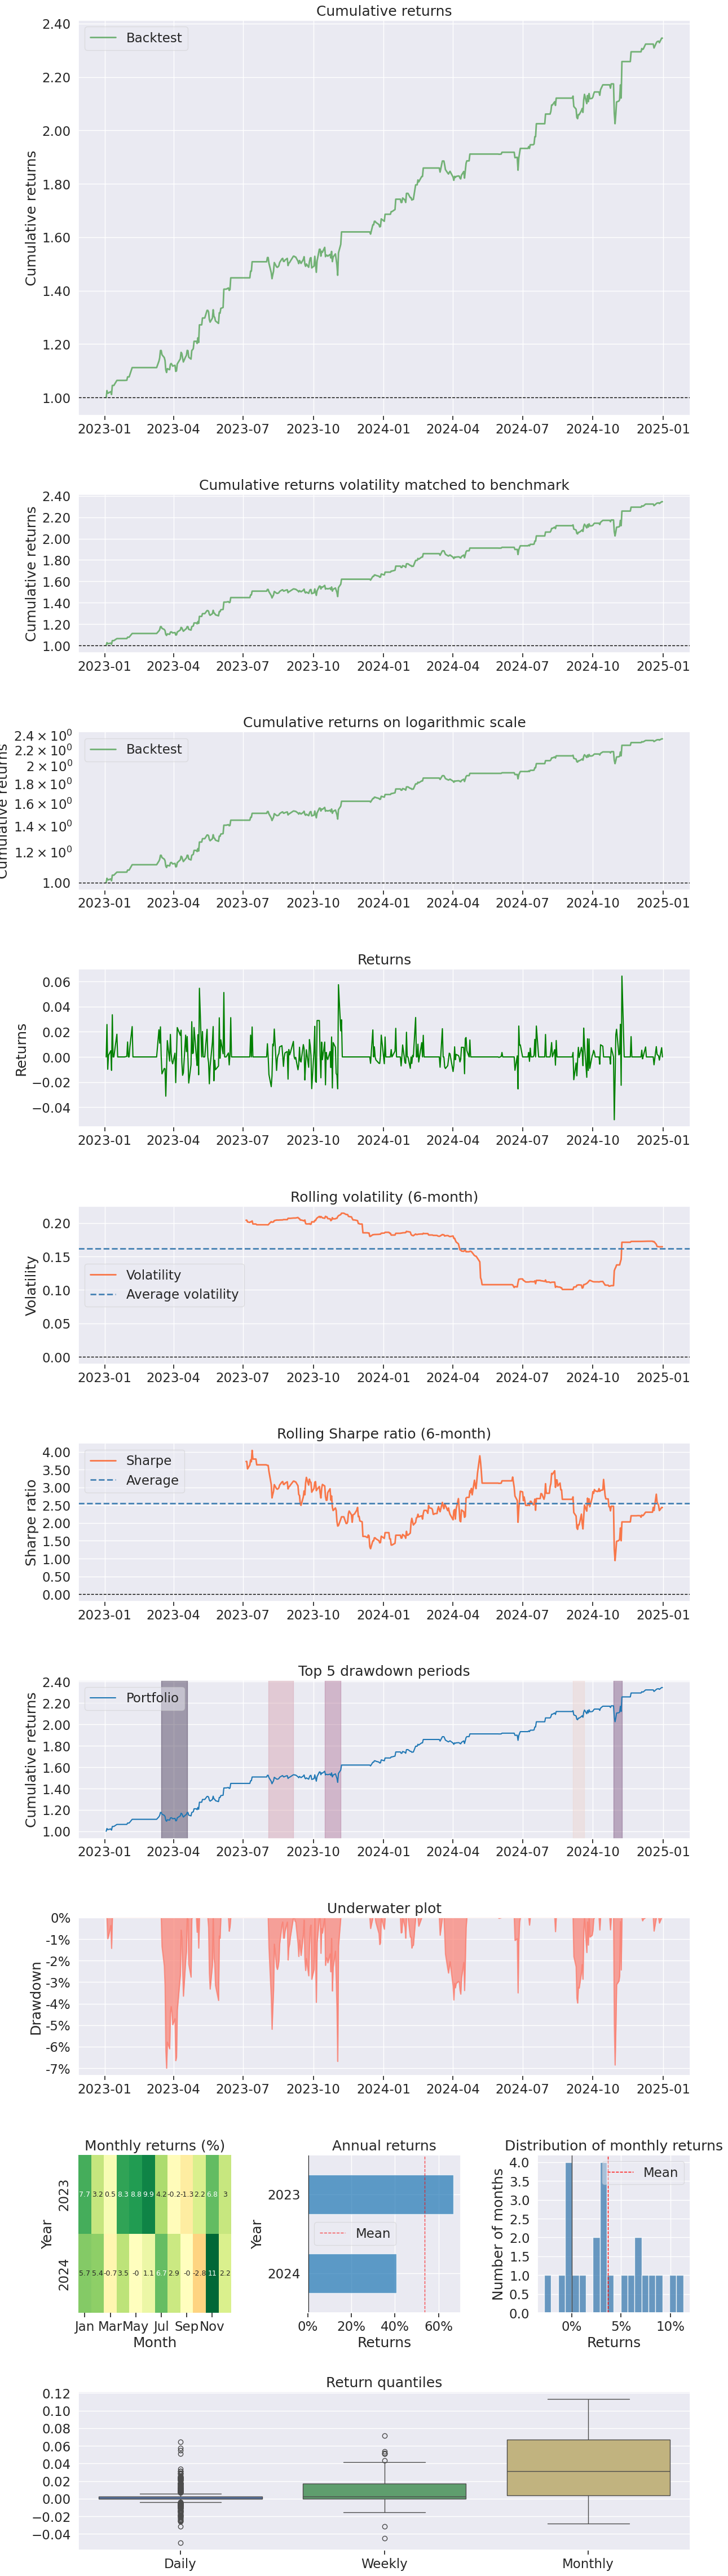

In [37]:
pf.create_full_tear_sheet(
    pnl_with_dates,
    round_trips=True,
    estimate_intraday=False,
)